# 51 Peg

In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
import copy

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define some functions for orbit fitting...

In [2]:
from numpy import log, exp, pi, sqrt, sin, cos, tan, arctan

def calc_ma(T0, t, period):
    # calculate mean anomaly
    days = t - T0
    phase = days/period % 1.0
    ma = phase * 2.0 * pi
    return ma
    
def calc_ea(ma, ecc):
    # calculate eccentric anomaly from mean anomaly, eccentricity
    tolerance = 1e-3
    ea = np.copy(ma)
    while True:
        diff = ea - ecc * sin(ea) - ma
        ea -= diff / (1. - ecc * cos(ea))
        if abs(diff).all() <= tolerance:
            break
    return ea
 
    
def calc_rvs(t,par):
    '''
    Calculate RV(t) given par
    par: [period, K, ecc, omega, M0, offset]
    where omega is the argument of periastron
    and Tp is time at periastron
    '''
    P,K,ecc,omega,tp,offset = par
    
    # enforce boundaries on parameters:
    #if (P < 0.0 or K < 0.0 or ecc < 0.0 or ecc > 0.999 or omega < 0. or omega > 2.*pi or M0 < 0. or M0 > 2.*pi):
    #    return np.zeros_like(t)
    #P = max([0.0, P])
    #K = max([0.0, K])
    #ecc = min([max([0.0, ecc]), 0.99])
    #omega = min([max([-pi, omega]), pi])
    #M0 = min([max([-pi, M0]), pi])
    
    ma = 2. * pi / P * (t - tp)  # mean anomaly
    ea = calc_ea(ma, ecc)  # eccentric anomaly

    f = 2.0 * np.arctan2(sqrt(1+ecc)*sin(ea/2.0), sqrt(1-ecc)*cos(ea/2.0)) # true anomaly
    rvs = - K * (cos(omega + f) + ecc*cos(omega))
    return rvs + offset

def calc_msini(P, K, ecc, Mstar=1.0):
    '''
    works in the limit that msini << Mstar
    takes:
    K - RV semi-amplitude in m/s
    P - period in days
    ecc - eccentricity (dimensionless)
    Mstar - host star mass in solar masses (default 1)
    returns:
    msini - minimum mass in Jupiters
    '''
    scaled_k = np.abs(K) / 28.4329 * np.sqrt(1. - ecc**2)
    msini = scaled_k * (P / 365.)**(1./3.) * Mstar**(2./3.)
    return msini

    
def keplerian(par,x):
    return calc_rvs(x, par)

def resid(par,fn,x,y,yerr):
    model = fn(par,x)
    return (y - model)/yerr 

Load up the results:

In [3]:
starid = '51peg'
a = wobble.Results() 
a2 = copy.deepcopy(a)
a.load_results('../results/'+starid+'_wobbleflow.hdf5')
a2.load_results('../results/'+starid+'_wobbleflow_telluricsfixed.hdf5')
data = wobble.Data(starid+'_e2ds.hdf5', filepath='../data/', 
                   orders=[40]) # just for pipeline results & BERVs

Text(0.5,0,'MJD')

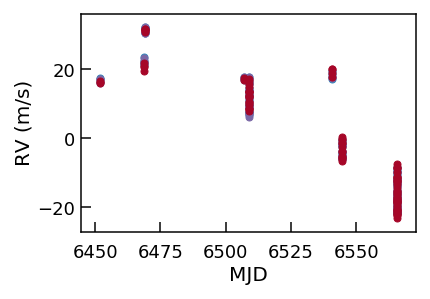

In [4]:
wobble_rvs = (a.time_rvs - data.bervs) - np.mean(a.time_rvs - data.bervs)
tfixed_rvs = (a2.time_rvs - data.bervs) - np.mean(a2.time_rvs - data.bervs)
pipeline_rvs = -1 * (data.pipeline_rvs - data.bervs) + np.mean(data.pipeline_rvs - data.bervs)
dates = data.dates - 2450000
plt.scatter(dates, wobble_rvs)
plt.scatter(dates, tfixed_rvs)
plt.scatter(dates, pipeline_rvs)
plt.ylabel('RV (m/s)', fontsize=20)
plt.xlabel('MJD', fontsize=20)

Text(0.5,0,'MJD')

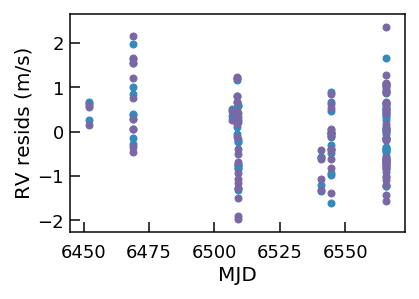

In [5]:
plt.scatter(dates, wobble_rvs - pipeline_rvs)
plt.scatter(dates, tfixed_rvs - pipeline_rvs)
plt.ylabel('RV resids (m/s)', fontsize=20)
plt.xlabel('MJD', fontsize=20)

### See how the planet fits compare:

In [46]:
def fit_planet(dates, rvs, sigs):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    par0 = np.asarray([4.2308, 55.65, 0.001, 90 * np.pi/180., 0., 0.])  # [period, K, ecc, omega, tp, offset]
    soln = leastsq(resid, par0, args=(keplerian, dates, rvs, sigs))
    
    par = soln[0]
    period = par[0]
    date_fold = dates % period
    ax1.errorbar(date_fold/period, rvs, sigs, fmt='o')
    xs = np.arange(0.,period,0.1)
    ax1.plot(xs/period, calc_rvs(xs, par), color='k')
    ax1.set_ylim([-80, 80])
    ax1.set_xticklabels('',visible=False)
    ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)

    ax2.set_ylim([-4, 4])


    resids = resid(par,keplerian,dates,rvs,sigs)
    ax2.errorbar(date_fold/period, resids, sigs, fmt='o')
    ax2.plot(xs/period, np.zeros_like(xs), color='k')
    print('chisq = {0:.2f}'.format(np.sum(resids**2/sigs**2)))
    print('resids RMS = {0:.2f} m/s'.format(np.std(resids)))
    print('planet period = {0:.4f} days'.format(period))
    print('planet msini = {0:.2f} MJup'.format(calc_msini(*par[:3])))
    fig.subplots_adjust(hspace=.05)
    ax2.set_ylabel('Resids', fontsize=16)
    ax2.set_xlabel('Orbital Phase', fontsize=16)
    plt.savefig('51peg_drs.png')

Wobble results (tellurics free)
chisq = 80.49
resids RMS = 0.94 m/s
planet period = 4.2307 days
planet msini = 0.46 MJup


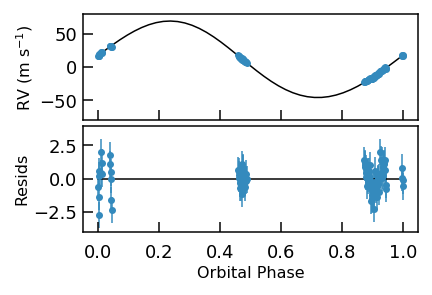

In [45]:
sigs = np.ones_like(dates)
dates -= dates[0]
print("Wobble results (tellurics free)")
fit_planet(dates, wobble_rvs, sigs)

Wobble results (tellurics fixed)
chisq = 101.49
resids RMS = 1.06 m/s
planet period = 4.2309 days
planet msini = 0.47 MJup


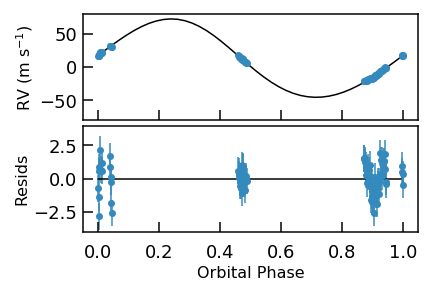

In [41]:
print("Wobble results (tellurics fixed)")
fit_planet(dates, tfixed_rvs, sigs)

HARPS pipeline results
chisq = 55.28
resids RMS = 0.78 m/s
planet period = 4.2293 days
planet msini = 0.42 MJup


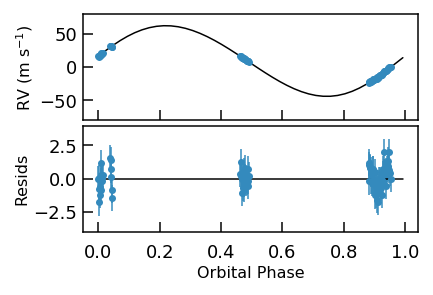

In [47]:
print("HARPS pipeline results")
fit_planet(dates, pipeline_rvs, sigs)